In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('continuous_factory_process.csv')
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

# FEATURE ENGINEERING

This notebook turns the noisy 1 Hz factory time series into structured features for modeling (XGBoost/ensembles).

Plan for feature engineering (high level):

1. **Sensor / data quality features**
   - Binary indicator for global sensor reset window (`sensor_reset`).

2. **Raw material properties (Stage 1, Machines 1–3)**
   - Normalize 12 raw material properties (scale differences are huge).
   - Machine-level change signals: any-change flags, time-since-change, recent change counts.

3. **Process variables (Stage 1 & combiner)**
   - Rolling statistics (mean/std/min/max) over multiple windows.

4. **Targets & label engineering**
   - Decide whether to predict Actuals, Setpoint error, or both for the 15 primary outputs.

In [2]:
# Sensor reset period: 2019-03-06 11:54:27 to 2019-03-06 12:03:10
reset_start = pd.to_datetime('2019-03-06 11:54:27')
reset_end = pd.to_datetime('2019-03-06 12:03:10')

# Create binary indicator for sensor reset period
df['sensor_reset'] = ((df['time_stamp'] >= reset_start) & (df['time_stamp'] <= reset_end)).astype(int)

/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_1635/1351479720.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sensor_reset'] = ((df['time_stamp'] >= reset_start) & (df['time_stamp'] <= reset_end)).astype(int)


In [3]:
# Feature Engineering: Raw Material Properties
# Get raw material columns for each machine
m1_raw_cols = df.columns[3:7].tolist()  # Machine 1: columns 3-6
m2_raw_cols = df.columns[15:19].tolist()  # Machine 2: columns 15-18
m3_raw_cols = df.columns[27:31].tolist()  # Machine 3: columns 27-30

# Store all raw material columns for feature engineering
all_raw_cols = m1_raw_cols + m2_raw_cols + m3_raw_cols
# Create features for each raw material property

# Store feature names for tracking
raw_material_features = []
new_features_dict = {}

for col in all_raw_cols:
    # 1. Binary change indicator
    change_col = f'{col}_changed'
    new_features_dict[change_col] = (df[col] != df[col].shift(1)).astype(int)
    raw_material_features.append(change_col)
    
    # 2. Normalized change magnitude (using std for normalization)
    # Change = current - previous, normalized by property's std
    prop_std = df[col].std()
    if prop_std > 0:
        change_mag_col = f'{col}_change_magnitude'
        change_mag = (df[col] - df[col].shift(1)) / prop_std
        new_features_dict[change_mag_col] = change_mag.fillna(0)  # First row has no previous value
        raw_material_features.append(change_mag_col)
    
    # 3. Time since last change (in seconds, since 1 Hz sampling)
    time_since_col = f'{col}_time_since_change'
    # Create a series that increments until a change occurs, then resets
    change_series = new_features_dict[change_col]
    change_indices = change_series[change_series == 1].index
    time_since = np.zeros(len(df))
    last_change_idx = -1
    for i in range(len(df)):
        if i in change_indices.values:
            last_change_idx = i
        if last_change_idx >= 0:
            time_since[i] = i - last_change_idx
    new_features_dict[time_since_col] = pd.Series(time_since, index=df.index)
    raw_material_features.append(time_since_col)

# Concatenate all new features at once to avoid fragmentation
new_features_df = pd.DataFrame(new_features_dict, index=df.index)
df = pd.concat([df, new_features_df], axis=1)

print(f"Created {len(raw_material_features)} individual raw material features")
print(f"Sample features: {raw_material_features[:6]}")

Created 36 individual raw material features
Sample features: ['Machine1.RawMaterial.Property1_changed', 'Machine1.RawMaterial.Property1_change_magnitude', 'Machine1.RawMaterial.Property1_time_since_change', 'Machine1.RawMaterial.Property2_changed', 'Machine1.RawMaterial.Property2_change_magnitude', 'Machine1.RawMaterial.Property2_time_since_change']


In [ ]:
# Create aggregated features per machine
# For each machine, create combined features
machine_raw_cols = {
    'M1': m1_raw_cols,
    'M2': m2_raw_cols,
    'M3': m3_raw_cols
}

aggregated_features_dict = {}

for machine, cols in machine_raw_cols.items():
    # Get change indicator columns for this machine
    change_cols = [f'{col}_changed' for col in cols]
    
    # 1. Total number of properties that changed at time t
    total_changes_col = f'{machine}_raw_total_changes'
    aggregated_features_dict[total_changes_col] = df[change_cols].sum(axis=1)
    raw_material_features.append(total_changes_col)
    
    # 2. Binary: Did any property change?
    any_change_col = f'{machine}_raw_any_change'
    aggregated_features_dict[any_change_col] = (aggregated_features_dict[total_changes_col] > 0).astype(int)
    raw_material_features.append(any_change_col)
    
    # 3. Time since any property changed (minimum time since change across all properties)
    time_since_cols = [f'{col}_time_since_change' for col in cols]
    min_time_col = f'{machine}_raw_min_time_since_change'
    aggregated_features_dict[min_time_col] = df[time_since_cols].min(axis=1)
    raw_material_features.append(min_time_col)
    
    # 4. Count of changes in rolling windows (5, 10, 30 minutes)
    for window_min in [5, 10, 30]:
        window_sec = window_min * 60  # Convert to seconds (1 Hz sampling)
        changes_count_col = f'{machine}_raw_changes_last_{window_min}min'
        aggregated_features_dict[changes_count_col] = aggregated_features_dict[total_changes_col].rolling(window=window_sec, min_periods=1).sum()
        raw_material_features.append(changes_count_col)

# Concatenate aggregated features at once
aggregated_features_df = pd.DataFrame(aggregated_features_dict, index=df.index)
df = pd.concat([df, aggregated_features_df], axis=1)

print(f"\nTotal raw material features created: {len(raw_material_features)}")

# Rare Changes -> normalize and keep larger changes in magnitude
useful_raw_features = []

for machine in ['M1', 'M2', 'M3']:
    # Keep these aggregated features
    useful_raw_features.extend([
        f'{machine}_raw_any_change',  # Binary: did any property change?
        f'{machine}_raw_min_time_since_change',  # Time since last change
        f'{machine}_raw_changes_last_5min',  # Recent change activity
        f'{machine}_raw_changes_last_10min',
        f'{machine}_raw_changes_last_30min'
    ])

scaler = StandardScaler()
normalized_raw_features = []

for col in all_raw_cols:
    normalized_col = f'{col}_normalized'
    df[normalized_col] = scaler.fit_transform(df[[col]])
    normalized_raw_features.append(normalized_col)

final_raw_features = useful_raw_features + normalized_raw_features
print(f"Final raw material features: {len(final_raw_features)}")
print(f"Final normalized raw material features: {len(normalized_raw_features)}")


Total raw material features created: 54
Final raw material features: 27
Final normalized raw material features: 12


/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_1635/509945474.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[normalized_col] = scaler.fit_transform(df[[col]])
/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_1635/509945474.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[normalized_col] = scaler.fit_transform(df[[col]])
/var/folders/b6/jws5h0lj06q57s7q669sqvf00000gn/T/ipykernel_1635/509945474.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

## Feature Informativeness Diagnostic

Quick assessment of how informative engineered features are for output prediction using:
1. **Correlation analysis** - Linear relationships
2. **Mutual information** - Non-linear relationships

In [5]:
target_col = 'Stage1.Output.Measurement0.U.Actual'

# Get feature columns
feature_cols = final_raw_features + ['sensor_reset']

# Prepare data (drop NaN in target)
diagnostic_df = df.dropna(subset=[target_col]).copy()
X = diagnostic_df[feature_cols]
y = diagnostic_df[target_col]

# Correlation Analysis

corrs = []
for feature in feature_cols:
    # Compute correlation, ignore NaN automatically (via pandas)
    corr = diagnostic_df[feature].corr(diagnostic_df[target_col])
    corrs.append((feature, corr))

corr_df = pd.DataFrame(corrs, columns=['Feature', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)


# Mutual Information Analysis 
# Compute mutual information (handles NaN by using valid samples)
mi_scores = mutual_info_regression(X, y, random_state=42, n_neighbors=3)

mi_df = pd.DataFrame({
    'Feature': feature_cols,
    'Mutual_Information': mi_scores
}).sort_values('Mutual_Information', ascending=False)

In [6]:
# Combined Analysis: Compare correlation vs mutual information

# Merge correlation and MI
combined_df = corr_df.merge(mi_df, on='Feature')
combined_df['Corr_Rank'] = combined_df['Abs_Correlation'].rank(ascending=False)
combined_df['MI_Rank'] = combined_df['Mutual_Information'].rank(ascending=False)
combined_df['Avg_Rank'] = (combined_df['Corr_Rank'] + combined_df['MI_Rank']) / 2

combined_df = combined_df.sort_values('Avg_Rank')

print(f"\nTop 15 features (by average rank of correlation + MI):")
print(combined_df[['Feature', 'Correlation', 'Mutual_Information', 'Avg_Rank']].head(15).to_string(index=False))

# Identify features that are informative in both metrics
print(f"\nFeatures informative in BOTH metrics (|corr| > 0.1 AND MI > 0.01):")
informative_both = combined_df[(combined_df['Abs_Correlation'] > 0.1) & (combined_df['Mutual_Information'] > 0.01)]
print(f"  Count: {len(informative_both)}")
if len(informative_both) > 0:
    print(informative_both[['Feature', 'Correlation', 'Mutual_Information']].to_string(index=False))


Top 15 features (by average rank of correlation + MI):
                                  Feature  Correlation  Mutual_Information  Avg_Rank
             M2_raw_min_time_since_change     0.088941            1.807060       3.5
Machine3.RawMaterial.Property2_normalized     0.106036            0.408974       5.5
Machine3.RawMaterial.Property4_normalized     0.114379            0.400284       6.0
Machine3.RawMaterial.Property3_normalized     0.059736            0.411477       6.0
             M1_raw_min_time_since_change    -0.053505            1.154542       6.0
Machine1.RawMaterial.Property1_normalized     0.055585            0.346812       9.5
                M2_raw_changes_last_30min    -0.165756            0.215122      10.0
Machine2.RawMaterial.Property2_normalized     0.052805            0.276623      11.5
Machine1.RawMaterial.Property2_normalized     0.043360            0.349766      12.0
             M3_raw_min_time_since_change     0.012528            1.450990      12.0
         

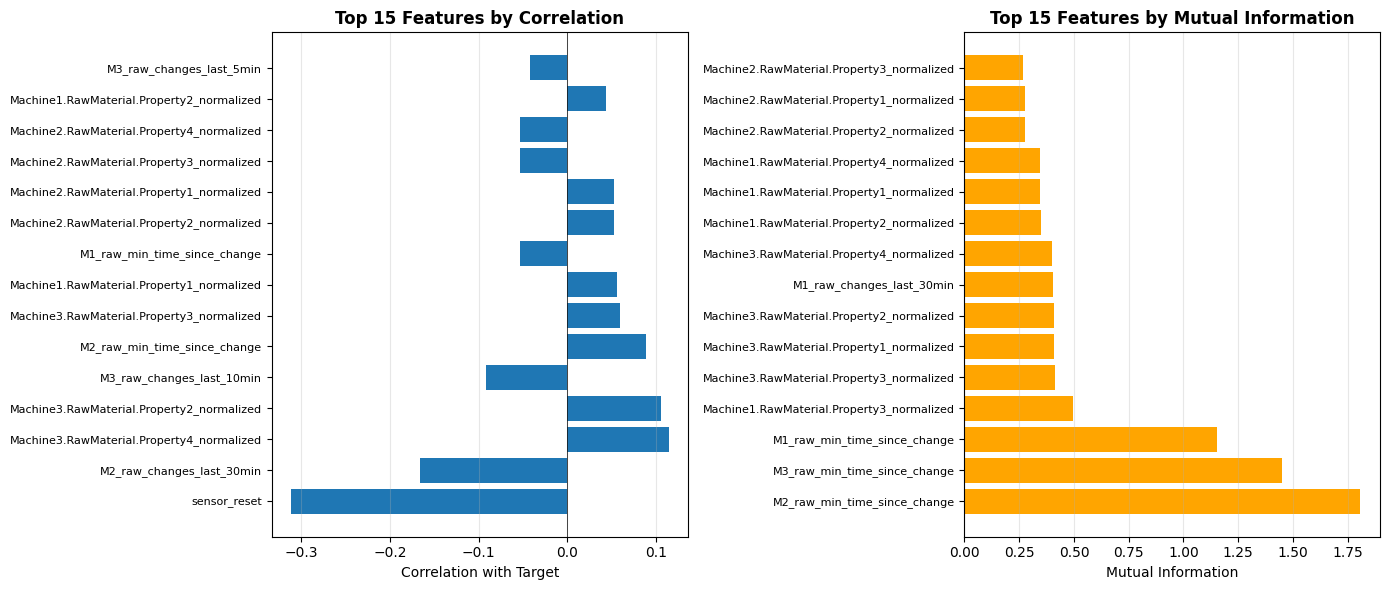

In [7]:
# Visualization: Correlation vs Mutual Information
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Correlation
ax1 = axes[0]
top_corr = corr_df.head(15)
ax1.barh(range(len(top_corr)), top_corr['Correlation'].values)
ax1.set_yticks(range(len(top_corr)))
ax1.set_yticklabels(top_corr['Feature'].values, fontsize=8)
ax1.set_xlabel('Correlation with Target', fontsize=10)
ax1.set_title('Top 15 Features by Correlation', fontsize=12, fontweight='bold')
ax1.axvline(0, color='black', linestyle='-', linewidth=0.5)
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Mutual Information
ax2 = axes[1]
top_mi = mi_df.head(15)
ax2.barh(range(len(top_mi)), top_mi['Mutual_Information'].values, color='orange')
ax2.set_yticks(range(len(top_mi)))
ax2.set_yticklabels(top_mi['Feature'].values, fontsize=8)
ax2.set_xlabel('Mutual Information', fontsize=10)
ax2.set_title('Top 15 Features by Mutual Information', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Interpretation

**Key Findings from Correlation & Mutual Information Analysis For Sensor Reset & Raw Materials Data:**

1. **Mutual Information reveals strong non-linear relationships:**
   - `M2_raw_min_time_since_change` (MI=1.78), `M3_raw_min_time_since_change` (MI=1.42), `M1_raw_min_time_since_change` (MI=1.13) are the most informative features
   - Normalized raw material properties have moderate MI (0.28-0.49)
   - **Conclusion**: Time since last material change is highly predictive, but relationships are **non-linear** 

2. **Correlation shows weak linear relationships:**
   - All correlations are weak (<0.2) except `sensor_reset` (-0.31, negative - resets cause output drops). This makes perfect sense.
   - Most features have correlations between -0.1 and 0.1. Linear Models will not work well!

**Implications:**
- Raw material features ARE informative (especially time-since-change features) - validates our feature engineering
- Still need process variable features (rolling statistics) - raw materials provide context but process variables likely drive most variance